<a href="https://colab.research.google.com/github/Alejandro-ZZ/Machine-Learning-UNS/blob/master/6_Regressors_Boston_Housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Boston Housing Dataset**

- Implementación de **modelos de regresión** para predecir los precios de venta de propiedades en la ciudad de Boston. 

- El dataset contiene 506 observaciones con 14 variables y precios de venta de las propiedades. Los datos se obtienen de [Kaggle | Boston Housing dataset](https://www.kaggle.com/altavish/boston-housing-dataset)

- Adicional, se realiza un proceso de selección de atributos para evaluar si esto permite mejorar el comportamiento de los regresores y disminuir los features con los que se entrena cada modelo.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [ ]:
data = pd.read_csv("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectBHP/data/housing_data.csv")
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,NaN,36.2


## **1. Variables**

La descripción de cada uno de los atributos es la siguiente:

* CRIM - tasa de criminalidad per cápita por ciudad
* ZN - proporción de suelo residencial zonificado para lotes de más de 25.000 ft^2.
* INDUS - proporción de acres comerciales no minoristas por ciudad.
* CHAS - Variable ficticia de Charles River (1 si el tramo limita con el río; 0 en caso contrario)
* NOX - concentración de óxidos nítricos (partes por 10 millones)
* RM - promedio de cuartos por vivienda
* AGE - proporción de unidades ocupadas por sus propietarios construidas antes de 1940
* DIS - distancias ponderadas a cinco centros de empleo de Boston
* RAD - índice de accesibilidad a carreteras radiales
* TAX - tasa de impuesto a la propiedad de valor total por $ 10,000

* PTRATIO - proporción de alumnos por maestro por ciudad
* B - 1000(Bk - 0.63)^2 donde Bk es la proporción de negros por ciudad
* LSTAT - % estado más bajo de la población
* MEDV - Valor medio de las viviendas ocupadas por sus propietarios en miles de dólares

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     486 non-null    float64
 1   ZN       486 non-null    float64
 2   INDUS    486 non-null    float64
 3   CHAS     486 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      486 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    int64  
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    486 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


Se observa que algunas variables carecen de 20 datos. Se trabajarán con dos subconjuntos a partir de ello: 

1. ***data_mean:*** se reemplazan los valores *Nan* con la media de datos para cada feature
2. ***data_drop:*** se eliminan las observaciones que contengan valores *Nan*.

In [ ]:
data_mean = data.fillna(data.mean())
data_drop = data.dropna()

print('Tamaño de datos reemplazados por su media')
print(data_mean.shape)
print('-'*37)
print('Tamaño de datos eliminados')
print(data_drop.shape)

Tamaño de datos reemplazados por su media
(506, 14)
-------------------------------------
Tamaño de datos eliminados
(394, 14)


In [ ]:
X_mean = data_mean.iloc[:,0:13]
y_mean = data_mean.iloc[:,13]

X_drop = data_drop.iloc[:,0:13]
y_drop = data_drop.iloc[:,13]

Ahora, se crea otro conjunto de datos con las variables escaladas

In [ ]:
scaler = StandardScaler()
scaler.fit(X_drop)
X_drop_norm = pd.DataFrame(scaler.transform(X_drop), columns=X_drop.columns)
print(X_drop_norm.describe())
print('-'*70)
scaler.fit(X_mean)
X_mean_norm = pd.DataFrame(scaler.transform(X_mean), columns=X_mean.columns)
print(X_mean_norm.describe())

## **2. Regresiones**

Para esta primer etapa, se aplican algunos regresores al conjunto de datos con todos los atributos y se observa su comportamiento.

In [ ]:
from sklearn.linear_model import LinearRegression, ElasticNetCV
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.preprocessing import PolynomialFeatures

# Conjunto de datos a evaluar
features = {
    'Drop': [X_drop, y_drop], 
    'Mean':[X_mean, y_mean],
    'Drop norm':[X_drop_norm, y_drop], 
    'Mean norm': [X_mean_norm, y_mean]
}

Se define una función que permita entrenar el modelo deseado y obtener los parámetros de calidad del mismo en un DataFrame.

In [ ]:
def train_model(model, datasets, multi_datasets=False, dataset_index=0):
  """
  Entradas:
    model           - Modelo de regresión a entrenar de Sklearn

    datasets        - Diccionario cuyo key es el nombre del dataset a entrenar 
                      y su valor es una lista con los features (X) en la 
                      posición 0 y la variable objetivo (y) en la posición 1.

    multi_datasets  - Indica si la etiqueta 'Dataset' del DataFrame de los 
                      resultados se indizan según el valor de 'dataset_index'.

    dataset_index   - Valor del índice para indezar los resultados de cada
                      entrenamiento del modelo.

  Output:
    Retorna un DataFrame con cuatro (4) columnas: 
      
      - 'Dataset': nombre del dataset con el que se entrenó el modelo.
      - 'R2 Train': puntuación R^2 del entrenamiento del regresor.
      - 'R2 Test': puntuación R^2 de la prueba del regresor.
      - 'CV Scores': puntaje medio con validación cruzada de 10-Folds.
  """

  # Parámetros de calidad
  r2_train_scores = []
  r2_test_scores = []
  cv_scores = []

  # Iteración para cada dataset
  for feature in datasets:

    X = datasets[feature][0]
    y = datasets[feature][1]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=23)

    model = model.fit(X_train, y_train)

    # Validación cruzada
    cv_score = cross_val_score(model, X_train, y_train, cv = 10)

    # R2 para los datos de entrenamiento
    y_pred_train = model.predict(X_train)
    r2_score_train = r2_score(y_train, y_pred_train)

    # R2 para los datos de prueba
    y_pred_test = model.predict(X_test)
    r2_score_test = r2_score(y_test, y_pred_test)

    # Se añaden los resultados
    r2_train_scores.append(r2_score_train)
    r2_test_scores.append(r2_score_test)
    cv_scores.append(cv_score.mean())

  if(multi_datasets):
    key_list = [keys + "_" + "X" + str(dataset_index) for keys in list(features.keys())]
  else:
    key_list = datasets.keys()
  
  dummy_df = pd.DataFrame({'Dataset': key_list, 'R2 Train': r2_train_scores,
                          'R2 Test': r2_test_scores, 'CV Scores': cv_scores})

  return dummy_df

De igual forma se define una función para entrenar un modelo por medio de GridSearch a partir de una lista de parámetros.

In [ ]:
from sklearn.model_selection import GridSearchCV

def train_gridSearch(model, params, datasets, multi_datasets=False, dataset_index=0):
  """
  Entradas:
    model           - Modelo de regresión a entrenar de Sklearn

    params          - Diccionario cuyos keys corresponden a los parámetros del
                      regresor y sus values son una lista con los valores a
                      probar en el GridSearch.

    datasets        - Diccionario cuyo key es el nombre del dataset a entrenar 
                      y su valor es una lista con los features (X) en la 
                      posición 0 y la variable objetivo (y) en la posición 1.

    multi_datasets  - Indica si la etiqueta 'Dataset' de los resultados se 
                      indizan según el valor de 'dataset_index'.

    dataset_index   - Valor del índice para indezar los resultados de cada
                      entrenamiento del modelo.

  Output:
    Retorna un DataFrame con seis (6) columnas: 
      
      - 'Dataset': nombre del dataset con el que se entrenó el modelo.
      - 'R2 Train': puntuación R^2 del entrenamiento del regresor.
      - 'R2 Test': puntuación R^2 de la prueba del regresor.
      - 'CV Scores': media de validación cruzada con 10-Folds.
      - 'Best Params': combinación de hiperparámetros que arroja el mejor puntaje
      - 'Best Score': puntaje medio con validación cruzada del mejor regresor
                      encontrado.
  """

  # Parámetros de calidad
  r2_train_scores = []
  r2_test_scores = []
  cv_scores = []

  best_params = []
  best_train_score = []

  for feature in datasets:

    X = datasets[feature][0]
    y = datasets[feature][1]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=23)


    param_tune = GridSearchCV(model, param_grid=params, cv=5)
    param_tune.fit(X_train, y_train)

    best_model = param_tune.best_estimator_

    # Validación cruzada
    cv_score = cross_val_score(best_model, X_train, y_train, cv = 10)

    # R2 para los datos de entrenamiento
    y_pred_train = best_model.predict(X_train)
    r2_score_train = r2_score(y_train, y_pred_train)

    # R2 para los datos de prueba
    y_pred_test = best_model.predict(X_test)
    r2_score_test = r2_score(y_test, y_pred_test)

    # Se añaden los resultados
    r2_train_scores.append(r2_score_train)
    r2_test_scores.append(r2_score_test)
    cv_scores.append(cv_score.mean())
    
    best_params.append(param_tune.best_params_)
    best_train_score.append(param_tune.best_score_)

  if(multi_datasets):
    key_list = [keys + "_" + "X" + str(dataset_index) for keys in list(datasets.keys())]
  else:
    key_list = datasets.keys()

  dummy_df = pd.DataFrame({'Dataset': key_list, 'R2 Train': r2_train_scores,
                          'R2 Test': r2_test_scores, 'CV Scores': cv_scores,
                          'Best Params': best_params, 'Best Score': best_train_score})
  return dummy_df

### **2.1. Lineal simple**

In [ ]:
regressor = LinearRegression()
results = train_model(model=regressor, datasets=features)
results

,Dataset,R2 Train,R2 Test,CV Scores
0,Drop,0.805698,0.637774,0.740923
1,Mean,0.746304,0.676384,0.716719
2,Drop norm,0.805698,0.637774,0.740923
3,Mean norm,0.746304,0.676384,0.716719


* Los datos reemplazados por su respectiva media (nombrados como `Mean` y `Mean norm`) presentan el mismo comportamiento y son los que mayor puntaje `R2 Test` obtienen. 

* Los datasets previos, sin embargo, son los que menor puntaje obtienen en la validación cruzada (`CV Scores`)

* Los datasets sin escalar y escalados presentan un comportamiento similar ya que se está evaluando una regresión lineal simple. 

### **2.2. ElasticNet**

In [ ]:
# Lista de alphas para evaluar en cada modelo
alphas = [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1]

regressor = ElasticNetCV(alphas=alphas, cv=5, random_state=23)

results = train_model(model=regressor, datasets=features)
results

,Dataset,R2 Train,R2 Test,CV Scores
0,Drop,0.805694,0.637806,0.740437
1,Mean,0.746131,0.675425,0.716270
2,Drop norm,0.805563,0.637072,0.737877
3,Mean norm,0.741370,0.670971,0.719007


* Los resultados no arrojan una mejora significativa respecto al modelo de regresión lineal simple

### **2.3. Random Forest**

In [ ]:
regressor = RandomForestRegressor(n_estimators=500, random_state=23)

results = train_model(model=regressor, datasets=features)
results

,Dataset,R2 Train,R2 Test,CV Scores
0,Drop,0.978782,0.764287,0.826530
1,Mean,0.983688,0.798000,0.876682
2,Drop norm,0.978810,0.764789,0.826700
3,Mean norm,0.983685,0.798158,0.876656


* En este caso, se observa un incremento en el puntaje R2 de prueba.

* Nuevamente, no se observa mayor diferencia entre los datos normalizados y los que no lo están.

* Los datos reemplazados por la media los que mejor comportamiento arrojan, tal como se vio en los regresores anteriores.

### **2.4. SVR**

In [ ]:
# Hiperparámetros para GridSearch
params = {
    'kernel': ['linear', 'poly', 'rbf'],
    'C': [0.01, 0.1, 1, 10, 100]
}

grid_results = train_gridSearch(model=SVR(), params=params, datasets=features)
grid_results

,Dataset,R2 Train,R2 Test,CV Scores,Best Params,Best Score
0,Drop,0.787047,0.589393,0.741858,"{'C': 10, 'kernel': 'linear'}",0.747964
1,Mean,0.707868,0.653928,0.697069,"{'C': 1, 'kernel': 'linear'}",0.668978
2,Drop norm,0.914087,0.727252,0.827985,"{'C': 10, 'kernel': 'rbf'}",0.833852
3,Mean norm,0.954544,0.852814,0.818632,"{'C': 100, 'kernel': 'rbf'}",0.823063


* Los conjuntos de datos que arrojan mejores puntajes son los cuales fueron normalizados.

* En este último regresor se observa el mayor puntaje R2 obtenido de 0.85 para los datos reemplazados por la media. La combinación de parámetros que logra este puntaje es de **C:100** y **kernel:'rbf'**

## **3. Feature selection**

* Evaluados los modelos con todos los atributos, ahora se intenta mejorar los mismos manteniendo o mejorando los puntajes al reducir la dimensionalidad. 

* Antes de seleccionar atributos, se analiza la relación de los mismos respecto a la variable objetivo. Gráficamente se observa el siguiente comportamiento:

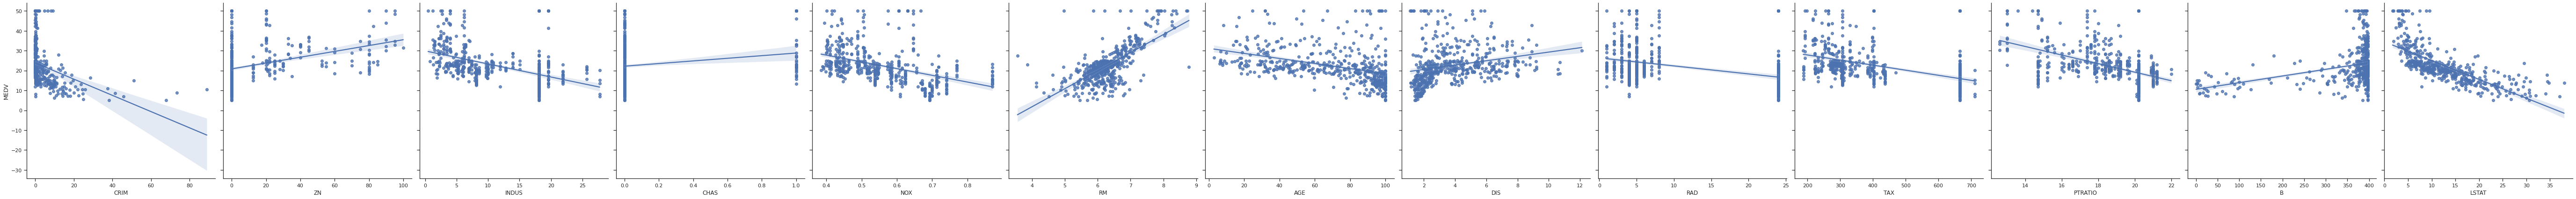

In [ ]:
x_vars = data.columns.tolist()[0:-1]

sns.set(style="ticks", color_codes=True)
sns.pairplot(data, x_vars=x_vars, y_vars='MEDV',  height=6, aspect=1., kind='reg')
plt.show()

* Se nota que, conforme aumenta el promedio de cuartos por vivienda (`RM`), también aumenta el precio medio de la vivienda (`MEDV`).

* Por lo contrario, entre más aumentan las variables `AGE` y `LSTAT` el precio medio de la vivienda (`MEDV`) disminuye.

* Algunos datos se encuentran saturados para valores `MEDV` alrededor de los $50.000 dólares

Analicemos ahora la **matriz de correlación**:

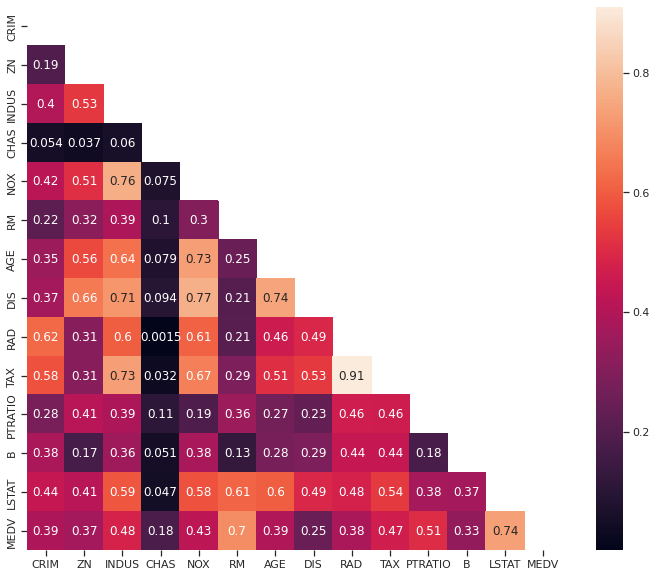

In [ ]:
corr_matrix = data.corr().abs()
plt.figure(figsize=(12,10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
#cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr_matrix, mask = mask, annot=True)
plt.show()

* Si se observa la correlación con la variable objetivo (**`MEDV`**) los atributos que mayor índice presenta son: `RM (0.7)` y `LSTAT (0.74)`. Esto coincide con lo observado en la representación gráfica previa. 

* El atributo `AGE` se encuentra por debajo de 0.5, esto en parte se debe a que, gráficamente, presenta alta varianza respecto a `MEDV`.

Analizado esto, se aplican diferentes **métodos de selección de atributos**.

In [ ]:
def fit_data(selector, datasets):
  # Dataset with features selected
  dataset = {}

  # Summary of features selected
  feats_selected = pd.DataFrame()

  for feature in datasets:
    X = datasets[feature][0]
    y = datasets[feature][1]

    selector.fit(X,y)

    columns = selector.get_feature_names_out()
    feats_selected[feature] = columns
    dataset[feature] = [X[columns], y]

  return (feats_selected, dataset)

### **3.1. Análisis univariado**

* En este primer análisis se seleccionarán **`k`** cantidad de atributos basado en una [prueba estadística univariada](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection). 

* Se implementa el método [SelectKBest de Sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html), el cual escoge los **`k`** mejores atributos basado en el método de prueba estadístico que se escoja.

* En esta aplicación se usará el método de F-test para regresión (**`f_regression`**, ya que la variable objetivo es continua) para encontrar cualquier tipo de dependencia lineal entre las variables independientes (X) y dependiente (y). La diferencia entre F-test y mutual information se explica en mayor profundidad en una [comparación de Sklearn](https://scikit-learn.org/stable/auto_examples/feature_selection/plot_f_test_vs_mi.html).

In [ ]:
from sklearn.feature_selection import SelectKBest 
from sklearn.feature_selection import f_regression

selector = SelectKBest(f_regression, k=6)
(data_selected, X1) = fit_data(selector=selector, datasets=features)

data_selected

,Drop,Mean,Drop norm,Mean norm
0,INDUS,INDUS,INDUS,INDUS
1,NOX,NOX,NOX,NOX
2,RM,RM,RM,RM
3,TAX,TAX,TAX,TAX
4,PTRATIO,PTRATIO,PTRATIO,PTRATIO
5,LSTAT,LSTAT,LSTAT,LSTAT


* Obsérvese que para esta primera selección, el resultado arroja las mismas features para los cuatro distintos datasets

### **3.2. Selección secuencial**

* En este análisis se eligen `n` atributos basado en una prueba secuencial a partir de un estimador.

* Se usa el método de [SequentialFeatureSelector de Sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html) el cual añade (forward) o elimina (backward) atributos conforme evalúa el comportamiento con un estimador especificado y elige el número de features deseados.

#### **3.2.1. Forward**

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector

estimator = RandomForestRegressor(random_state=23)
selector = SequentialFeatureSelector(estimator=estimator, n_features_to_select=6)
(data_selected, X2) = fit_data(selector=selector, datasets=features)

data_selected

,Drop,Mean,Drop norm,Mean norm
0,CHAS,ZN,CHAS,ZN
1,NOX,CHAS,NOX,CHAS
2,RM,NOX,RM,NOX
3,AGE,RM,AGE,RM
4,PTRATIO,PTRATIO,PTRATIO,PTRATIO
5,LSTAT,LSTAT,LSTAT,LSTAT


* Para este caso, cambian los atributos seleccionados entre los cuatro datasets. Sin embargo, los dos conjuntos de datos denominados *Drop* obtienen las mismas columnas, de la misma forma que sucede con los datos reemplazados por la media (*Mean*) 

#### **3.2.2. Backward**

In [ ]:
estimator = RandomForestRegressor(random_state=23)
selector = SequentialFeatureSelector(estimator=estimator, n_features_to_select=6, direction='backward')

(data_selected, X3) = fit_data(selector=selector, datasets=features)

data_selected

,Drop,Mean,Drop norm,Mean norm
0,CRIM,CRIM,CRIM,CRIM
1,RM,NOX,RM,NOX
2,AGE,RM,AGE,RM
3,DIS,DIS,DIS,DIS
4,PTRATIO,PTRATIO,PTRATIO,PTRATIO
5,LSTAT,LSTAT,LSTAT,LSTAT


* Respecto a la dirección Forward, las features seleccionadas son diferentes. Sin embargo, se presenta el mismo fenómeno del ejemplo anterior, los datos *Drop* comparten mismos atributos al igual que los datos *Mean*.

### **3.3. Recursive Feature Elimination (RFE)**

* Este análisis es similar al análisis univariado, sin embargo, los `n` atributos deseados se toman a partir de la importancia que arroja un estimador especificado.

* La selección se aplica usando el módulo [RFE de Sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html), el cual implementa un estimador externo que asigne pesos a los atributos del dataset.

In [ ]:
from sklearn.feature_selection import RFE

estimator = RandomForestRegressor(random_state=23)
selector = RFE(estimator=estimator, n_features_to_select=6)

(data_selected, X4) = fit_data(selector=selector, datasets=features)

data_selected

,Drop,Mean,Drop norm,Mean norm
0,CRIM,CRIM,CRIM,CRIM
1,NOX,NOX,NOX,NOX
2,RM,RM,RM,RM
3,DIS,DIS,DIS,DIS
4,PTRATIO,PTRATIO,PTRATIO,PTRATIO
5,LSTAT,LSTAT,LSTAT,LSTAT


* Similar al análisis univariado, los cuatro conjunto de datos comparten las mismas features, pero estas son diferentes a este análisis.

### **3.4. Evaluación**

In [ ]:
# Feature selection datasets
feat_results = [X1, X2, X3, X4]

#### 3.4.1. Lineal simple

In [ ]:
#train_model(model, datasets, multi_datasets=False, dataset_index=0)
metrics = pd.DataFrame()
i = 1

for datasets in feat_results:
  train_results = train_model(model=LinearRegression(), datasets=datasets,
                              multi_datasets=True, dataset_index=i)
  i+=1
  metrics = pd.concat([metrics, train_results])
metrics.reset_index().drop('index', axis=1).sort_values('R2 Test', ascending=False).head()

,Dataset,R2 Train,R2 Test,CV Scores
11,Mean norm_X3,0.705355,0.689993,0.687460
15,Mean norm_X4,0.705355,0.689993,0.687460
9,Mean_X3,0.705355,0.689993,0.687460
13,Mean_X4,0.705355,0.689993,0.687460
3,Mean norm_X1,0.679371,0.647880,0.655806


* Para el regresor lineal simple, el mejor puntaje de prueba obtenido es de 0.689; ligeramente mayor al obtenido con todas las features donde se obtuvo un puntaje máximo de 0.676

#### 3.4.2. ElasticNet

In [ ]:
#train_model(model, datasets, multi_datasets=False, dataset_index=0)
metrics = pd.DataFrame()
i = 1

# Lista de alphas para evaluar en cada modelo
alphas = [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1]
regressor = ElasticNetCV(alphas=alphas, cv=5, random_state=23)

for datasets in feat_results:
  train_results = train_model(model=regressor, datasets=datasets,
                              multi_datasets=True, dataset_index=i)
  i+=1
  metrics = pd.concat([metrics, train_results])
metrics.reset_index().drop('index', axis=1).sort_values('R2 Test', ascending=False).head()

,Dataset,R2 Train,R2 Test,CV Scores
11,Mean norm_X3,0.705323,0.689972,0.688645
15,Mean norm_X4,0.705323,0.689972,0.688645
9,Mean_X3,0.705216,0.687815,0.686661
13,Mean_X4,0.705216,0.687815,0.686661
3,Mean norm_X1,0.678316,0.652347,0.661481


* Al igual que anterior regresor, se nota un incremento leve en el puntaje de prueba de 0.689 a comparación de 0.675 obtenido en el modelo entrenado con todos los atributos.

#### 3.4.3. Random Forest

In [ ]:
#train_model(model, datasets, multi_datasets=False, dataset_index=0)
metrics = pd.DataFrame()
i = 1

regressor = RandomForestRegressor(n_estimators=500, random_state=23)

for datasets in feat_results:
  train_results = train_model(model=regressor, datasets=datasets,
                              multi_datasets=True, dataset_index=i)
  i+=1
  metrics = pd.concat([metrics, train_results])
metrics.reset_index().drop('index', axis=1).sort_values('R2 Test', ascending=False).head()

,Dataset,R2 Train,R2 Test,CV Scores
3,Mean norm_X1,0.978766,0.809065,0.836241
1,Mean_X1,0.978736,0.808771,0.836143
7,Mean norm_X2,0.976341,0.798681,0.814979
5,Mean_X2,0.976337,0.798232,0.815230
11,Mean norm_X3,0.983017,0.797447,0.872738


* A comparación de los resultados obtenidos con todas las features, el modelo mejora de un puntaje máximo de 0.798 a 0.809

#### 3.4.4. SVR

In [ ]:
metrics = pd.DataFrame()
i = 1

# Hiperparámetros para GridSearch
params = {
    'kernel': ['linear', 'poly', 'rbf'],
    'C': [0.01, 0.1, 1, 10, 100]
}

for datasets in feat_results:
  grid_results = train_gridSearch(model=SVR(), params=params, datasets=datasets,
                                  multi_datasets=True, dataset_index=i)
  i+=1
  metrics = pd.concat([metrics, grid_results])
metrics.reset_index().drop('index', axis=1).sort_values('R2 Test', ascending=False).head()

,Dataset,R2 Train,R2 Test,CV Scores,Best Params,Best Score
11,Mean norm_X3,0.923905,0.841896,0.799296,"{'C': 100, 'kernel': 'rbf'}",0.807748
15,Mean norm_X4,0.923905,0.841896,0.799296,"{'C': 100, 'kernel': 'rbf'}",0.807748
7,Mean norm_X2,0.846584,0.828263,0.774914,"{'C': 10, 'kernel': 'rbf'}",0.764944
3,Mean norm_X1,0.851021,0.827209,0.806630,"{'C': 10, 'kernel': 'rbf'}",0.795944
9,Mean_X3,0.839989,0.797013,0.795081,"{'C': 100, 'kernel': 'rbf'}",0.785574


* En este caso el puntaje de prueba obtenido (0.841) es levemente menor que al arrojado con el modelo entrenado con todas las features (0.852).

## **4. Feature reduction**

### **4.1. Análisis de componentes principales (PCA)**

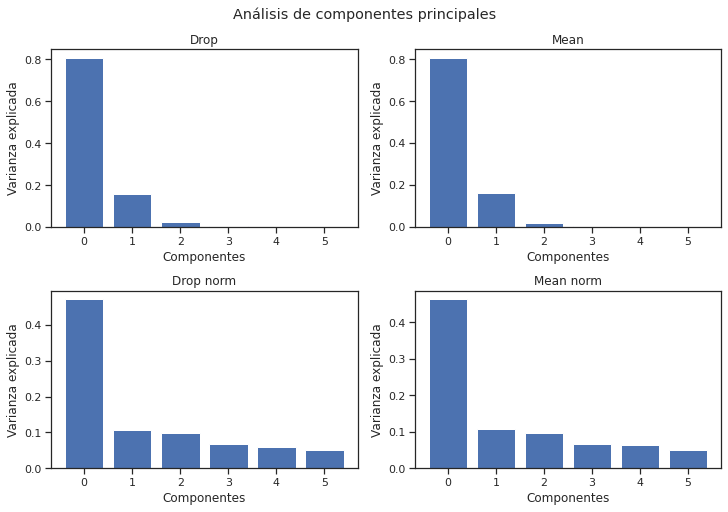

In [ ]:
from sklearn.decomposition import PCA

fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(10,7))
fig.suptitle('Análisis de componentes principales')

row = 0
col = 0

for feature in features:
  X = features[feature][0]
  y = features[feature][1]

  selector = PCA(n_components=6, random_state=23).fit(X)

  x_ = range(len(selector.explained_variance_))
  y_ = selector.explained_variance_ratio_

  axs[row, col].set_title(feature)
  axs[row, col].set_xlabel("Componentes")
  axs[row, col].set_ylabel("Varianza explicada")
  axs[row, col].bar(x_, y_)

  col += 1
  if col == 2:
    col = 0
    row = 1

plt.show()

* Se observa que, para los datos no normalizados, con apenas las dos (2) primeras componentes se logra explicar casi todo el comportamiento de las demás features.

* Por lo contrario, para los datos que se normalizan, las dos (2) primeras componentes apenas logran explicar menos del 60% de la varianza del dataset.

Ahora se extraen las componentes principales para cada uno de los cuatro datasets (Drop, Mean, Drop norm, Mean norm).

In [ ]:
pca_datasets = {}
for feature in features:
  X = features[feature][0]
  y = features[feature][1]

  selector = PCA(n_components=6, random_state=23).fit_transform(X)

  dummy_df = pd.DataFrame(data = selector, columns = [('PCA' + str(n)) for n in range(1,7)])
  pca_datasets[feature] = [dummy_df, y]

### **4.2. Evaluación**

El proceso de evaluación se realiza con los modelos Random Forest y SVR ya que son los que mejor comportamiento han arrojado para el dataset tratado.

#### 4.2.1. Random Forest

In [ ]:
regressor = RandomForestRegressor(n_estimators=500, random_state=23)

results = train_model(model=regressor, datasets=pca_datasets)
results

,Dataset,R2 Train,R2 Test,CV Scores
0,Drop,0.958601,0.630931,0.686532
1,Mean,0.952146,0.648407,0.599687
2,Drop norm,0.969853,0.685421,0.741702
3,Mean norm,0.965299,0.738371,0.723230


#### 4.2.2. SVR

In [ ]:
# Hiperparámetros para GridSearch
params = {
    'kernel': ['linear', 'poly', 'rbf'],
    'C': [0.01, 0.1, 1, 10, 100]
}

grid_results = train_gridSearch(model=SVR(), params=params, datasets=pca_datasets)
grid_results

,Dataset,R2 Train,R2 Test,CV Scores,Best Params,Best Score
0,Drop,0.633117,0.414431,0.586719,"{'C': 100, 'kernel': 'rbf'}",0.577434
1,Mean,0.583041,0.436440,0.537502,"{'C': 100, 'kernel': 'rbf'}",0.509784
2,Drop norm,0.875588,0.651900,0.800651,"{'C': 10, 'kernel': 'rbf'}",0.815199
3,Mean norm,0.858608,0.715463,0.756641,"{'C': 100, 'kernel': 'rbf'}",0.753921


* Para ambos modelos evaluados, se observa un puntaje inferior al obtenido en la sección de `Feature Selection`. Sin embargo, para este caso, se descomponen los atributos iniciales (14) y se combinan de manera que generan apenas 6 componentes con una relativa alta varianza explicada.

## **5. Conclusiones**

* En el primer análisis con los cuatro (4) `regresores`, se encontró que SVR fue el que mejor comportamiento arrojó con un puntaje de prueba R2 de 0.85, un kernel de tipo 'rbf' y un parámetro de regularización (C) de 100.

* Para el primer entrenamiento de los regresores con todo los atributos, los dos dataset que mejor comportamiento arrojaron fueeron los reemplazador por la media de los datos (*Mean* y *Mean Norm*).

* Luego de reducir la cantidad de atributos de 14 a 6, en la etapa (3) `Feature Selection`, se observa que, en general, los regresores tienen un comportamiento ligeramente distinto al obtenido entrenándolos con todas las features. Si bien no es una mejora significativa, se debe resaltar que los resultados se obtienen con menos de la mitad de los atributos iniciales.

* Al evaluar la sección de `Feature Selection`, se observa que las técnicas que mejores resultados arrojan son: selección secuencial backward (X3) y eliminación recursiva RFE (X4). Sin embargo, para el modelo de Random Forest, los mejores resultados se obtienen con el análisis univariado (X1).

* Dentro de la evaluación en la sección de `Feature Selection` es de resaltar que los conjuntos de datos que mejores resultados arrojaron fueron los dataset cuyos datos tipo *Nan* fueron reemplazados por la media (*Mean* y *Mean norm*) tal como se observó en la etapa dos (2): `Regresiones`.

* En la sección de `Feature Selection` se escogen 6 de 14 atributos. Este número es tomado de manera aleatoria para el laboratorio, sin embargo, no es necesariamente el número de atributos que optimiza el comportamiento de los regresores.

* Si bien en la sección de `Feature Reduction` no se logra superar el mejor comportamiento obtenido en pruebas anteriores, solo se implementa una de varias técnicas ([PCA | Sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)) para lograr esta finalidad. Además, se eligen seis (6) componentes, lo cual fue tomado de manera arbitraria. Una alternativa a ello es implementar enfoques como el método `Maximum Likelihood Estimation (MLE)` de Minka (incluido los parámetros de PCA con Sklearn) para estimar la cantidad de componentes para el dataset.

* Analizando el comportamiento en la evaluación, de los modelos con el resultado de la técnica de PCA aplicada, se encuentra que en esta ocación los datasets que mayor puntaje obtienen son los cuales fueron escalados (*Drop Norm* y *Mean Norm*).

* [RFECV](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html) es una alternativa de Sklearn que permite explorar el comportamiento de un determinado modelo ante la variación de los atributos elegidos. Usando la validación cruzada elige la cantidad de features que permite obtener el mejor resultado para el modelo elegido.

## **6. Links relacionados**

**Feature selection**

* [Feature selection methods](https://www.analyticsvidhya.com/blog/2016/12/introduction-to-feature-selection-methods-with-an-example-or-how-to-select-the-right-variables/): blog explicativo de los métodos para selección de atributos.

* [Dimensionality reduction techniques](https://www.analyticsvidhya.com/blog/2018/08/dimensionality-reduction-techniques-python/): blog sobre distintas técnicas de reducción en dimensionalidad en Python.

* [Feature Selection en Python](https://machinelearningmastery.com/feature-selection-machine-learning-python/): ejemplos en Python para selección de atributos y preparación de modelos en machine learning con Sklearn.

* [Sklearn Documentation | Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html): documentación de Sklearn sobre la selección de atributos y los métodos ofrecidos por este paquete en Python.

* [Recursive Feature Elimination (RFE) for Feature Selection in Python](https://machinelearningmastery.com/rfe-feature-selection-in-python/): explicación y ejemplos de la implementación de RFE y RFECV con python.


**Información general**

* [Implementing Linear Regression with Categorical variable Using Sklearn](https://medium.com/analytics-vidhya/implementing-linear-regression-using-sklearn-76264a3c073c)

* [Linear models Sklearn](https://scikit-learn.org/stable/modules/linear_model.html#robustness-regression-outliers-and-modeling-errors)

* [Linear Regression Example GitHub](https://github.com/manlio99/Materia-de-aprendizaje/blob/master/5_DataMining/1_regression.ipynb)

* [Polynomial regression sklearn](https://towardsdatascience.com/machine-learning-polynomial-regression-with-python-5328e4e8a386)

* [Boston Housing regression example](https://www.kaggle.com/tolgahancepel/boston-housing-regression-analysis)